### Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен **АБ-тест**. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

**Ваша задача**: оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
users = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

Проверим данные:

In [4]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [5]:
products.shape

(87, 3)

In [6]:
products.isnull().sum()

product_id    0
name          0
price         0
dtype: int64

In [7]:
products.nunique()

product_id    87
name          87
price         63
dtype: int64

In [8]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [9]:
orders.shape

(4123, 3)

In [10]:
orders.isnull().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [11]:
orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [12]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [13]:
users.shape

(4337, 6)

In [14]:
users.isnull().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [15]:
users.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [16]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Выглядит так, что с данными все в порядке

In [17]:
users.date = pd.to_datetime(users.date)

In [18]:
users.date.max() - users.date.min()

Timedelta('13 days 00:00:00')

Хмм, достаточно ли такого количества времени для экперимента?

Посчитаем соотношение отмен к сделанным заказам

In [19]:
cr = users.groupby(['group', 'action']).agg({'user_id':'count'}).reset_index()
cr

,group,action,user_id
0,0,cancel_order,82
1,0,create_order,1609
2,1,cancel_order,132
3,1,create_order,2514


In [20]:
round((cr.user_id[0] / cr.user_id[1])*100, 2)

5.1

In [21]:
round((cr.user_id[2] / cr.user_id[3])*100, 2)

5.25

Процент отмен заказов не особо отличается в двух группах

Избавимся от заказов пользователей, по которым были отмены:

In [22]:
#отмены
cancelled_orders = users.query('action == "cancel_order"').order_id

In [23]:
#заказы без отмен
created_orders = users.query('order_id not in @cancelled_orders')

In [24]:
orders_new = created_orders.merge(orders, on = 'order_id')

In [25]:
orders_new.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"


In [26]:
orders_new = orders_new.drop(columns=['time']) #время оказалось одинаковым, дропнем
orders_new['product_ids'] = orders_new.product_ids.str.strip('{}')

In [27]:
orders_new['product_ids'] = orders_new['product_ids'].str.split(',')
orders_new = orders_new.explode('product_ids')
orders_new.head()

,user_id,order_id,action,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,75
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,22
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,53
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,84
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21.000000,56


In [28]:
orders_new = orders_new.rename(columns = {'product_ids':'product_id'})

In [29]:
orders_new['product_id'] = orders_new.product_id.astype('int64')

In [30]:
orders_new

,user_id,order_id,action,date,group,creation_time,product_id
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,75
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,22
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,53
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,84
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21.000000,56
...,...,...,...,...,...,...,...
3907,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06.000000,9
3907,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06.000000,62
3907,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06.000000,77
3908,1376,59533,create_order,2022-09-08,0,2022-09-08 23:41:24.000000,17


In [31]:
df = orders_new.merge(products, how = 'outer', on = 'product_id')

In [32]:
df.head()

,user_id,order_id,action,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


Фуф, подготовка завершена, посмотрим прибыль по группам

In [33]:
df.groupby('group', as_index = False).agg({'price':'sum'})

,group,price
0,0,583455.9
1,1,878628.4


Как минимум выросла прибыль с новой системой рекомендации,не будем делать поспешных выводов, повлиять на прибыль могло что-то другое <br>


Посмотрим выросло ли среднее количество заказов одним пользователем

In [34]:
orders_number = df.groupby(['group', 'user_id'], as_index = False)\
        .agg({'order_id':'nunique'})\
        .rename(columns = {'order_id':'orders_number'})

In [35]:
orders_number.groupby(['group'], as_index = False).orders_number.mean()

,group,orders_number
0,0,2.982422
1,1,4.754491


Выросло среднее количество заказов на одно пользователя

- $H_0$: среднее количество заказов в группах не отличается
- $H_1$: среднее количество заказов в группах отличается

In [36]:
ttest_ind(orders_number.query('group == 1').orders_number, orders_number.query('group == 0').orders_number)

Ttest_indResult(statistic=13.993124788985595, pvalue=8.430777321728061e-41)

Казалось бы, p-value значительно меньше 0.05 и можно отвергать нулевую гипотезу, но не торопимся с выводами

Стоит посчитать и средний чек на один заказ у пользователя

In [37]:
mean_check = df.groupby(['group', 'user_id', 'order_id'], as_index = False)\
        .agg({'price':'sum'})
mean_check.groupby(['group'], as_index = False).price.mean()

,group,price
0,0,382.092927
1,1,368.861629


Средний чек особо не изменился, но стоит проверить статистически ли значимо отличие

- $H_0$: средний чек в группах не отличается
- $H_1$: средний чек в группах отличается

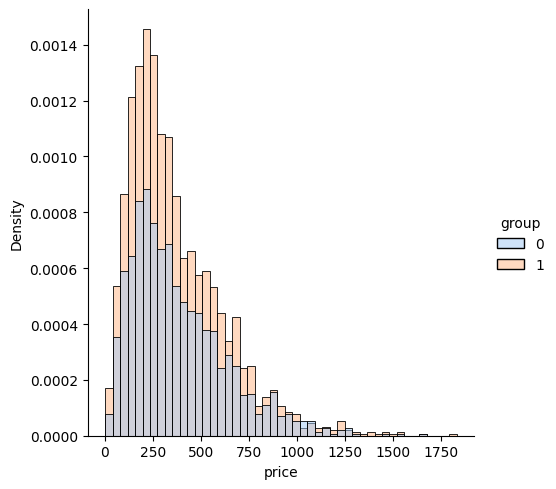

In [38]:
figsize=(20, 12)
sns.displot(mean_check, x="price", hue="group", stat="density", palette="pastel")

In [39]:
ttest_ind(mean_check.query('group == 1').price, mean_check.query('group == 0').price)

Ttest_indResult(statistic=-1.6334875192269538, pvalue=0.10244707728234388)

По среднему чеку не можем отвергнуть нулевую гипотезу, смотрим дальше на среднее количество товаров в заказе

In [40]:
mean_positions_number = df.groupby(['group', 'order_id'], as_index = False)\
        .agg({'product_id':'count'})
mean_positions_number.groupby(['group'], as_index = False).product_id.mean()

,group,product_id
0,0,3.341847
1,1,3.350126


В целом видно, что они очень близки, но давайте все же посмотрим
- $H_0$: среднее количество товаров в заказе в группах не отличается
- $H_1$: среднее количество товаров в заказе в группах отличается

In [41]:
ttest_ind(mean_positions_number.query('group == 1').product_id, mean_positions_number.query('group == 0').product_id)

Ttest_indResult(statistic=0.19638057741712578, pvalue=0.84432251088501)

Среднее количество товаров в заказе тоже не сильно отличается, p-value тоже не позволяет откинуть нулевую гипотезу

In [42]:
dates = df.groupby(['group', 'date', 'order_id'], as_index = False)\
        .agg({'action':'count'})

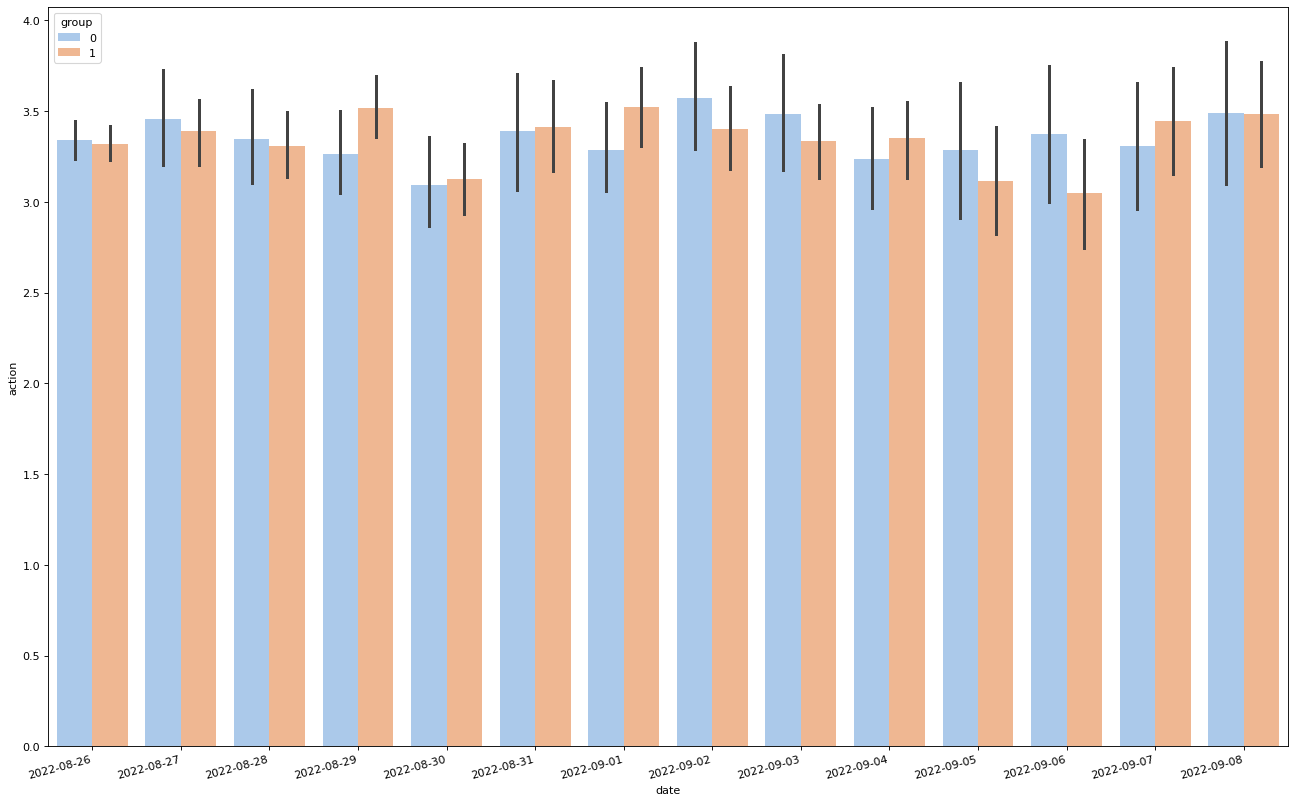

In [43]:
f, ax = plt.subplots(figsize=(20, 12), dpi= 80)
sns.barplot(data=dates, x="date", y="action", hue="group", palette="pastel")
x_dates = dates['date'].dt.strftime('%Y-%m-%d').unique()
ax.set_xticklabels(labels=x_dates, rotation=15, ha='right')
plt.show()

### Итого:

- Выросло среднее количество заказов на пользователя => выросла прибыль
- Не изменился средний чек и среднее количество товаров купленных 

Учитывая, что средний чек не изменился, а число заказов выросло, выручки у нас явно стало больше. А значит, это довольно серьёзное свидетельство в пользу выкатывания новой системы.